### Monte Carlo Simulation
A method of estimating the value of an unknown quantity using the principles of inferential statistics. 

We take the **population** and then we **sample** it by drawing a proper subset. And then we make an inference about the population based upon some set of statistics we do on the sample.

And, the key fact that makes them work, that if we choose the sample at **random**, the sample will tend to exhibit the same properties as the population from which it is drawn.

### Option Pricing Techniques 

As with other option pricing techniques Monte Carlo methods are used to price options using what is essentially a three step process.

**Step 1:** Simulate potential price paths of the underlying asset.<br>
**Step 2:** Calculate the option payoff for each of these price paths.<br>
**Step 3:** Average the payoff and discount back to today to determine the option price.

### Generate Price Paths
Simulating price paths plays an important role in the valuation of derivatives and it is always prudent to create a separate path function.

**Import Required Libraries**

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set max row to 300
pd.set_option('display.max_rows', 300)

#### User Defined Function

In [2]:
# Generate path
def simulate_path(spot, mu, sigma, horizon, timesteps, nsims):
    
    # set the seed
    np.random.seed(2025)

    # define dt
    dt = horizon/timesteps
    
    # simulate path
    S = np.zeros((timesteps,nsims))
    S[0] = spot
    
    for i in range(0, timesteps-1):
        w = np.random.standard_normal(nsims)
        S[i+1] = S[i] * (1+ mu*dt + sigma*np.sqrt(dt)*w)
    
    return S

#### Histogram of Psuedo Random Numbers

In [3]:
# Assign simulated price path to dataframe for analysis and plotting
price_path = pd.DataFrame(simulate_path(100,0.05,0.2,1,252,100000))

# Verify the generated price paths
price_path.head()

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,99.903441,100.944954,98.207020,99.184008,99.892936,102.724790,101.775748,99.758578,100.981871,100.278185,...,99.613474,101.845737,100.902556,101.123928,100.150958,100.125869,99.244602,102.528947,98.674810,100.180191
2,99.345214,101.821660,98.723040,98.018993,98.590876,100.206093,102.780763,100.825784,99.375341,101.584694,...,101.978604,102.259856,101.782055,99.808803,101.683364,98.076991,99.104893,106.595556,98.097037,100.064025
3,100.998181,99.599020,98.790151,99.624174,100.366497,98.660929,104.576009,101.014763,97.242001,100.591981,...,101.005549,101.559175,103.727754,102.179913,101.507059,100.612370,99.786156,105.829691,96.198639,100.832572
4,100.988982,100.433012,98.781391,101.429466,100.558523,100.081110,104.385652,101.268674,96.429088,100.041747,...,103.980785,99.045037,104.456082,102.287960,102.839965,100.304590,100.911626,106.214315,97.059590,101.301550


#### Histogram of Simulated Paths

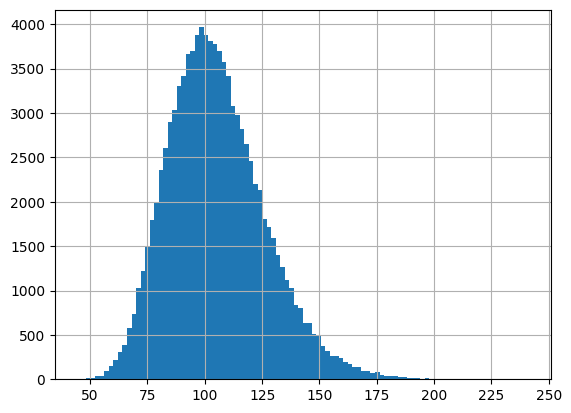

In [4]:
# Plot the histogram of the simulated price path at maturity
price_path.iloc[-1].hist(bins=100);

#### Visualization of Simulated Paths

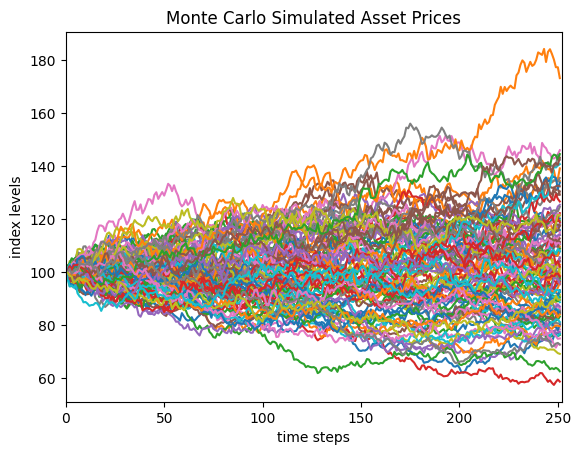

In [5]:
# Plot initial 100 simulated path using matplotlib
plt.plot(price_path.iloc[:,:100])
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('index levels')
plt.title('Monte Carlo Simulated Asset Prices');

#### European Option

To price an option, we generate many possible price paths that the asset might take at maturity and then calculate option payoffs for each of those generated prices, average them to get the expected payoff and then discount it at risk free to arrive at the final value.

Given that Monte Carlo algorithms are computationaly heavy, it is necessary to implement efficiently. We'll use vectorization with NumPy for effective algorithm as NumPy syntax are more compact and are faster.

In [6]:
# Call the simulation function
S = simulate_path(100,0.05,0.2,1,252,100000)

# Define parameters
K = 100; r = 0.05; T=1

In [7]:
# Calculate the discounted value of the expeced payoff
C0 = np.exp(-r*T) * np.mean(np.maximum(0, S[-1]-K))
P0 = np.exp(-r*T) * np.mean(np.maximum(0, K-S[-1]))

# Print the values
print(f"European Call Option Value is {C0:0.4f}")
print(f"European Put Option Value is {P0:0.4f}")

European Call Option Value is 10.4275
European Put Option Value is 5.5600


#### Asian Call Option 

An Asian option is an option where the payoff depends on the average price of the underlying asset over a certain period of time. Averaging can be either be Arithmetic or Geometric. There are two types of Asian options: **fixed strike**, where averaging price is used in place of underlying price; and **fixed price**, where averaging price is used in place of strike.

We'll now price a fixed strike arthmetic average option using Monte Carlo simulation.

In [8]:
# Average price
A = S.mean(axis=0)

C0 = np.exp(-r*T) * np.mean(np.maximum(0, A-K))
P0 = np.exp(-r*T) * np.mean(np.maximum(0, K-A))

# Print the values
print(f"Asian Call Option Value is {C0:0.4f}")
print(f"Asian Put Option Value is {P0:0.4f}")

Asian Call Option Value is 5.7502
Asian Put Option Value is 3.3399


In [9]:
# Call the simulation function
S = simulate_path(100,0.05,0.2,1,252,100000)

# Define parameters
K=100; B=150; r=0.05; sigma=0.20; T=1; t=252; dt=T/t; barrier_rebate = 0

# Barrier shift - continuity correction for discrete monitoring
barrier_shift = B*np.exp(0.5826*sigma*np.sqrt(dt))

# Calculate the discounted value of the expeced payoff
C0 = np.exp(-r*T) * np.mean(np.where(np.max(S, axis=0) < barrier_shift, np.maximum(S[-1,:] - K, 0), barrier_rebate))

# Print the values 
print(f"Up-and-Out Barrier Call Option Value is {C0:0.4f}")

Up-and-Out Barrier Call Option Value is 7.9694


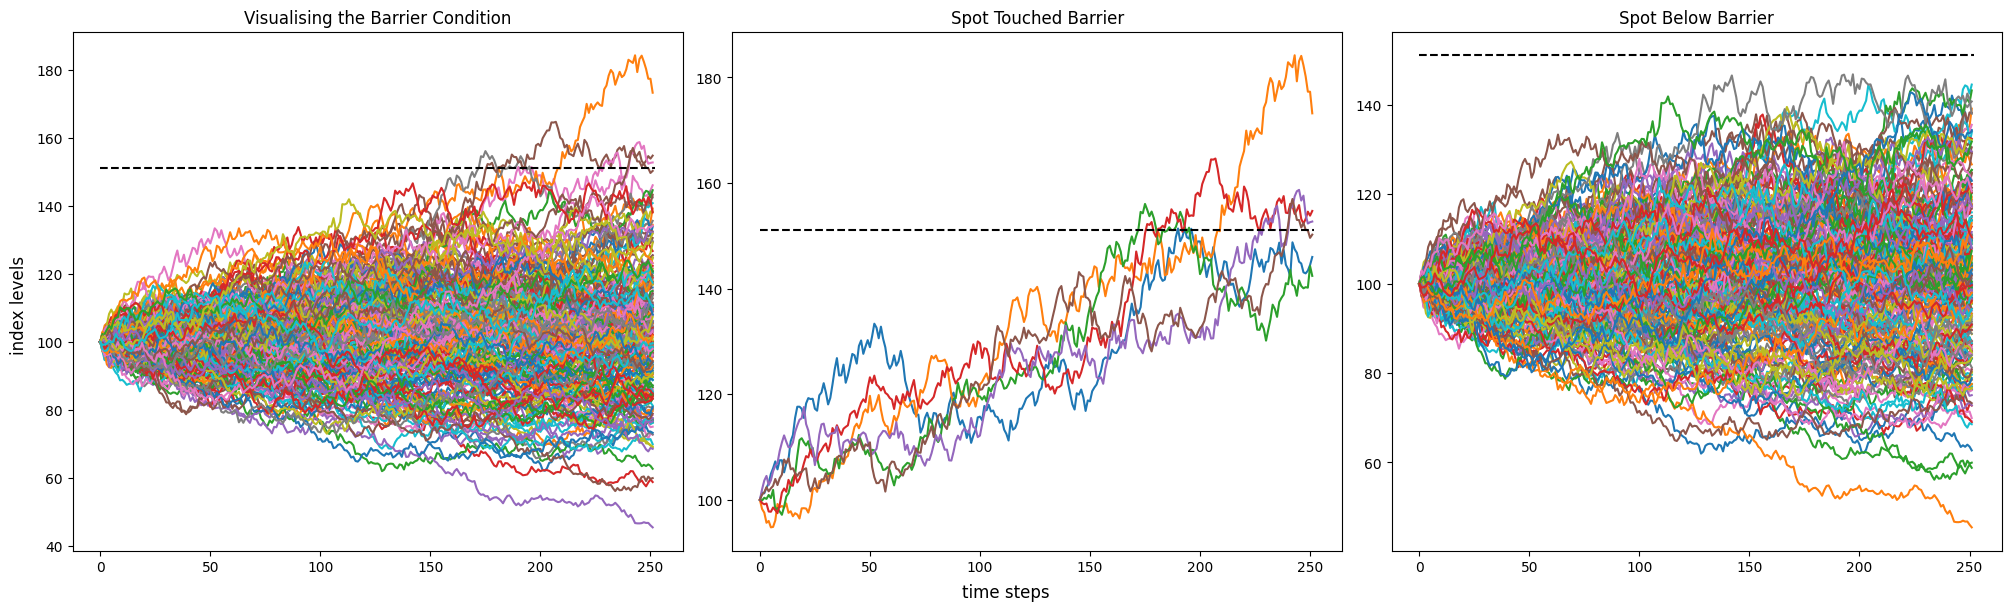

In [10]:
figure, axes = plt.subplots(1,3, figsize=(20,6), constrained_layout=True)
title = ['Visualising the Barrier Condition', 'Spot Touched Barrier', 'Spot Below Barrier']

axes[0].plot(S[:,:200])      
for i in range(200):
    axes[1].plot(S[:,i]) if S[:,i].max() > barrier_shift else axes[2].plot(S[:,i])

for i in range(3):
    axes[i].set_title(title[i])
    axes[i].hlines(barrier_shift, 0, 252, colors='k', linestyles='dashed')

figure.supxlabel('time steps')
figure.supylabel('index levels')

plt.show()